In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Set, Optional

In [2]:
def show_image(image, label=''):
    if len(image.shape) > 2:
        image = image[..., ::-1]
    plt.imshow(image, label=label)
    plt.axis('off')
def show_images(images, labels, plot_size=(2, 2), figsize=(16, 16)):
    r, c = plot_size[0], plot_size[1]
    plt.figure(figsize=figsize)
    
    for i in range(len(images)):
        plt.subplot(r, c, i + 1)
        show_image(images[i], label=labels[i])
        
    for i in range(len(images), r * c):
        plt.subplot(r, c, i)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Cấu hình mặc định
CONFIG = {
    "green_bgr": [0, 255, 0],
    "coin_diameter_mm": 21.25,
    "hue_range_lower": 40,
    "hue_range_upper": 20,
    "saturation_threshold": 85,
    "value_threshold": 85,
    "min_radius_coin": 10,
    "max_radius_coin": 60,
    "min_distance_circles": 50,
    "canny_lower": 50,
    "canny_upper": 150,
    "hough_param1": 50,
    "hough_param2": 30,
    "blur_kernel_size": (5, 5),
    "blur_sigma": 1,
    "median_blur_ksize": 5,
    "min_contour_area": 2000,
}

def get_color_thresholds(color_bgr: List[int], config: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Chuyển đổi màu BGR sang HSV và xác định ngưỡng màu.

    Args:
        color_bgr: Màu ở định dạng BGR (Blue, Green, Red).
        config: Dictionary chứa các tham số cấu hình.

    Returns:
        Tuple containing lower and upper thresholds in HSV space.
    """
    color_array = np.uint8([[color_bgr]])
    hsv_color = cv2.cvtColor(color_array, cv2.COLOR_BGR2HSV)
    hue = hsv_color[0][0][0]
    
    lower = (
        hue - config["hue_range_lower"],
        config["saturation_threshold"],
        config["value_threshold"]
    )
    upper = (hue + config["hue_range_upper"], 255, 255)
    
    return (np.array(lower, dtype=np.uint8), np.array(upper, dtype=np.uint8))

def create_mask(hsv_image: np.ndarray, color_bgr: List[int], config: Dict) -> np.ndarray:
    """
    Tạo mask nhị phân dựa trên ngưỡng màu.

    Args:
        hsv_image: Ảnh trong không gian màu HSV.
        color_bgr: Màu cần phân đoạn (định dạng BGR).
        config: Dictionary chứa các tham số cấu hình.

    Returns:
        Binary mask of the segmented region.
    """
    lower, upper = get_color_thresholds(color_bgr, config)
    mask = cv2.inRange(hsv_image, lower, upper)
    return cv2.medianBlur(mask, config["median_blur_ksize"])

def find_contours(mask: np.ndarray) -> Tuple[List[np.ndarray], np.ndarray]:
    """
    Tìm contours và hierarchy từ mask nhị phân.

    Args:
        mask: Mask nhị phân.

    Returns:
        Tuple of contours and hierarchy.
    """
    contours, hierarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    return contours, hierarchy

def detect_circles(image: np.ndarray, config: Dict) -> Tuple[Optional[np.ndarray], np.ndarray, np.ndarray]:
    """
    Phát hiện các vòng tròn trong ảnh bằng HoughCircles.

    Args:
        image: Ảnh gốc ở định dạng BGR.
        config: Dictionary chứa các tham số cấu hình.

    Returns:
        Tuple of detected circles, grayscale image, and edge image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    gray = cv2.GaussianBlur(gray, config["blur_kernel_size"], config["blur_sigma"])
    edges = cv2.Canny(gray, config["canny_lower"], config["canny_upper"])
    
    circles = cv2.HoughCircles(
        edges, cv2.HOUGH_GRADIENT, dp=1, minDist=config["min_distance_circles"],
        param1=config["hough_param1"], param2=config["hough_param2"], 
        minRadius=config["min_radius_coin"], maxRadius=config["max_radius_coin"]
    )
    return circles, gray, edges

def process_circles(circles: np.ndarray, result_image: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Xử lý các vòng tròn: vẽ tất cả vòng tròn và chọn vòng tròn đầu tiên làm đồng xu.

    Args:
        circles: Mảng các vòng tròn được phát hiện.
        result_image: Ảnh để vẽ các vòng tròn.

    Returns:
        Tuple of selected coin (circle) and scale factor (mm/pixel).
    """
    circles = np.uint16(np.around(circles))
    for coin in circles[0]:
        cv2.circle(result_image, (coin[0], coin[1]), coin[2], (255, 0, 0), 4)
    
    coin = circles[0][0]
    coin_diameter_px = coin[2] * 2
    scale = CONFIG["coin_diameter_mm"] / coin_diameter_px
    return coin, scale

def calculate_contour_area(contours: List[np.ndarray], hierarchy: np.ndarray, 
                         idx: int, processed: Set[int]) -> float:
    """
    Tính diện tích thực tế của một contour (ngoài trừ trong).

    Args:
        contours: Danh sách contours.
        hierarchy: Hierarchy của contours.
        idx: Chỉ số của contour cần tính.
        processed: Tập hợp các contour đã xử lý.

    Returns:
        Diện tích thực tế (pixel).
    """
    outer_area = cv2.contourArea(contours[idx])
    inner_area = 0
    child_idx = hierarchy[0][idx][2]
    
    while child_idx != -1:
        inner_area += cv2.contourArea(contours[child_idx])
        processed.add(child_idx)
        child_idx = hierarchy[0][child_idx][0]
    
    return outer_area - inner_area

def draw_valid_contours(mask: np.ndarray, contours: List[np.ndarray], 
                       idx: int, hierarchy: np.ndarray) -> None:
    """
    Vẽ contour hợp lệ lên mask, trừ đi các vùng bên trong.

    Args:
        mask: Mask để vẽ contours.
        contours: Danh sách contours.
        idx: Chỉ số contour cần vẽ.
        hierarchy: Hierarchy của contours.
    """
    cv2.drawContours(mask, [contours[idx]], -1, 255, -1)
    child_idx = hierarchy[0][idx][2]
    while child_idx != -1:
        cv2.drawContours(mask, [contours[child_idx]], -1, 0, -1)
        child_idx = hierarchy[0][child_idx][0]

def compute_area(image_path: str, config: Dict = CONFIG, min_area: int = None) -> Dict[str, np.ndarray]:
    """
    Tính diện tích lá dựa trên ảnh và đồng xu làm tham chiếu.

    Args:
        image_path: Đường dẫn đến file ảnh.
        config: Dictionary chứa các tham số cấu hình. Mặc định là CONFIG.
        min_area: Diện tích tối thiểu của contour. Mặc định lấy từ config.

    Returns:
        Dictionary chứa các ảnh và thông tin liên quan.
    """
    if min_area is None:
        min_area = config["min_contour_area"]
    
    # Đọc và kiểm tra ảnh
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {image_path}")
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    result = image.copy()
    
    # Phân vùng lá và tìm contours
    leaf_mask = create_mask(hsv, config["green_bgr"], config)
    contours, hierarchy = find_contours(leaf_mask)
    if not contours:
        raise ValueError("Không tìm thấy contour nào trong ảnh.")
    
    # Phát hiện đồng xu
    circles, gray, edges = detect_circles(image, config)
    final_mask = np.zeros_like(leaf_mask)
    
    if circles is None:
        print("Không phát hiện được đồng xu.")
        return [image, hsv, gray, edges, result, final_mask], ['Original', 'HSV', 'Gray', 'Edges', 'Result', 'Mask']
    
    # Xử lý đồng xu
    coin, scale = process_circles(circles, result)
    
    # Tính diện tích lá
    total_area_px = 0
    total_area_mm2 = 0
    processed = set()
    valid_contours = []
    
    for i in range(len(contours)):
        if i in processed or hierarchy[0][i][3] != -1:
            continue
        
        true_area_px = calculate_contour_area(contours, hierarchy, i, processed)
        if true_area_px <= 0 or true_area_px < min_area:
            continue
        total_area_px += true_area_px
        
        true_area_mm2 = true_area_px * (scale ** 2)
        total_area_mm2 += true_area_mm2
        valid_contours.append(contours[i])
        draw_valid_contours(final_mask, contours, i, hierarchy)
    
    # Vẽ kết quả
    cv2.drawContours(result, valid_contours, -1, (0, 0, 255), 2)
    cv2.circle(result, (coin[0], coin[1]), coin[2], (0, 255, 255), -1)
    print(f'Total area in px = {total_area_px}')
    print(f'Total area in mm2 = {total_area_mm2}')
    
    return [image, hsv, gray, edges, result, final_mask], ['Original', 'HSV', 'Gray', 'Edges', 'Result', 'Mask']

Total area in px = 117170.5
Total area in mm2 = 18144.651545353227


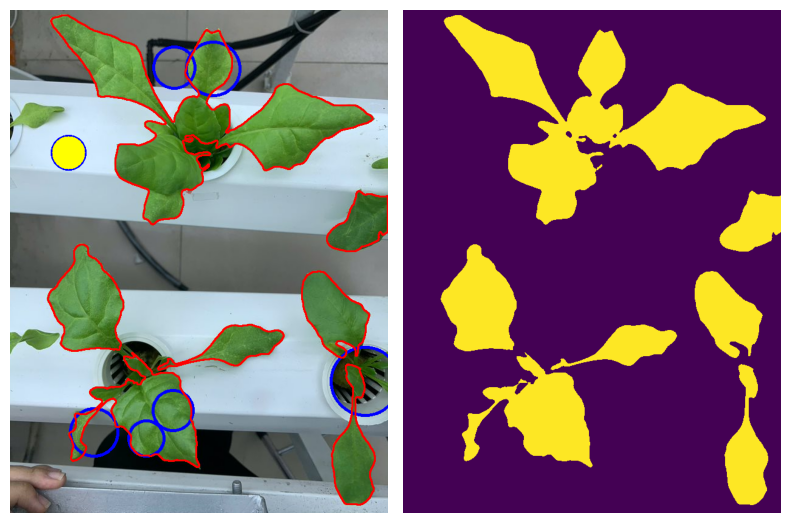

In [5]:
image_path = 'images/im1.jpg'
images, labels = compute_area(image_path)
# compute_area(image_path)
show_images(images[-2:], labels[-2:], plot_size=(1, 2), figsize=(8, 14))

Total area in px = 905129.5
Total area in mm2 = 32583.11063805405


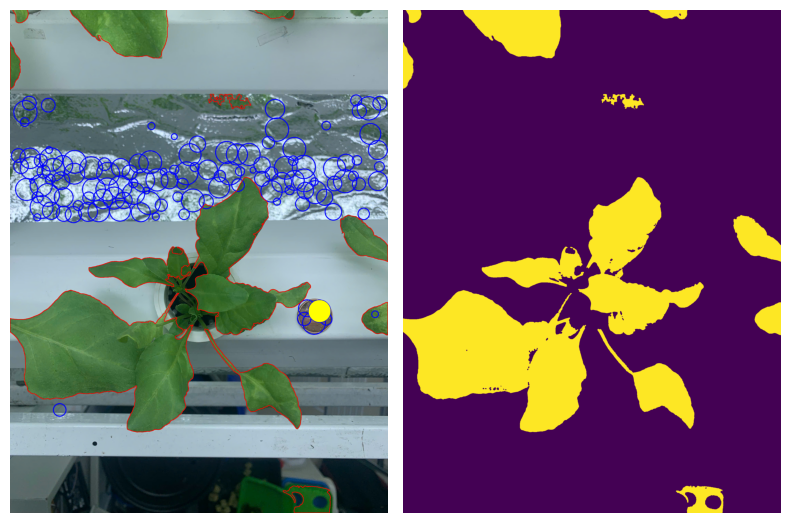

In [6]:
image_path = 'images/im2.jpg'
images, labels = compute_area(image_path)
# compute_area(image_path)
show_images(images[-2:], labels[-2:], plot_size=(1, 2), figsize=(8, 14))

Total area in px = 30737.0
Total area in mm2 = 1445.1974763119533


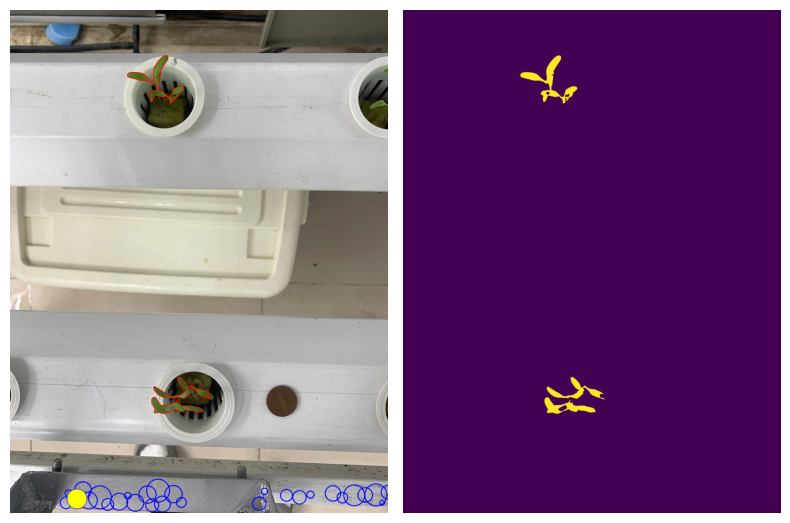

In [7]:
image_path = 'images/im3.jpg'
images, labels = compute_area(image_path)
# compute_area(image_path)
show_images(images[-2:], labels[-2:], plot_size=(1, 2), figsize=(8, 14))